In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

from matplotlib import font_manager

font_family = font_manager.FontProperties(fname='C:/Windows/Fonts/malgunsl.ttf').get_name()
plt.rc('font', family=font_family)

In [2]:
def url_parser(sDate, eDate, row=10):
    key="개인코드"
    
    url="http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson?serviceKey="+key
    url=url+"&pageNo=1&numOfRows="+str(row)
    url=url+"&startCreateDt="+str(sDate)
    url=url+"&endCreateDt="+str(eDate)
    
    xml_soup=requests.get(url)
    
    if xml_soup.status_code != 200:
        print('API 연결 오류')
        exit()
        
    soup=bs(xml_soup.text, 'html.parser')
    
    return soup

In [8]:
def covid_info(soup):
    items=soup.find_all('item')
    
    covid_list=[]
    for item in tqdm(items, desc='진행율='):
        stdDay=item.find('stdday').get_text()        # 기준일
        stdDay=stdDay.replace("년 ","").replace("월 ","")[0:8]  
        ### 년,월 글자 제거 후 8자리 가져오기(일 00시, 일 18시, 일 17시 등 제거)
        gubun=item.find('gubun').get_text()          # 지역명
        incDec=item.find('incdec').get_text()        # 당일 확진자
        defCnt=item.find('defcnt').get_text()        # 누적 확진자
        localCnt=item.find('localocccnt').get_text() # 지역
        overCnt=item.find('overflowcnt').get_text()  # 해외
        
        covid_list.append([stdDay, gubun, incDec, localCnt, overCnt, defCnt])
        
    df1=pd.DataFrame(covid_list, columns=['기준일', '지역명', '당일', '지역', '해외', '누적'])
    df1=df1.astype({'당일':"int64", "지역":"int64", "해외":"int64", "누적":"int64"})# 데이터 형식 변경
    df1['기준일']=pd.to_datetime(df1['기준일'])
    df1.sort_values(by='기준일', inplace=True)   # 기준일을 기준으로 오름차순 정렬
    df1.reset_index(drop=True, inplace=True)
    
    return df1

In [11]:
sDate='20210701'
eDate=datetime.datetime.today().strftime('%Y%m%d')

soup=url_parser(sDate, eDate)
row=soup.find('totalcount').text
soup=url_parser(sDate, eDate, row)
df1=covid_info(soup)

진행율=: 100%|█████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 8602.24it/s]


In [25]:
df2=df1[df1['지역명']=='경기'][['기준일', '당일']]
df2=df2.rename(columns={'당일':'경기'})
df3=df1[df1['지역명']=='서울'][['기준일', '당일']]
df3=df3.rename(columns={'당일':'서울'})
#display(df2)
#display(df3)
df2=pd.merge(df2, df3, on='기준일')  # merge(): 사용자가 지정한 열을 기분으로 열 추가
df2

,기준일,경기,서울
0,2021-07-01,249,333
1,2021-07-02,264,347
2,2021-07-03,252,359
3,2021-07-04,231,289
4,2021-07-05,220,307
5,2021-07-06,229,320
6,2021-07-07,367,583
7,2021-07-08,392,550
8,2021-07-09,405,503
9,2021-07-10,451,509


In [26]:
loc_list=df1['지역명'].unique()[1:]
loc_list

array(['검역', '제주', '경남', '경북', '전남', '전북', '충남', '충북', '서울', '경기', '부산',
       '대구', '인천', '강원', '대전', '울산', '세종', '광주'], dtype=object)

In [29]:
df0=df1[df1['지역명']=="합계"][['기준일', '당일']]
df0=df0.rename(columns={'당일':'합계'})

for locName in loc_list:
    df2=df1[df1['지역명']==locName][['기준일', '당일']]
    df2=df2.rename(columns={'당일':locName})
    df0=pd.merge(df0, df2, on='기준일')

In [35]:
df0=df0[['기준일', '합계','검역','서울', '경기','인천','부산', '대구','대전', '울산', '세종', '광주',
     '강원','경남', '경북', '전남', '전북', '충남', '충북','제주']]
df0.set_index('기준일', inplace=True)
df0.head()

,합계,검역,서울,경기,인천,부산,대구,대전,울산,세종,광주,강원,경남,경북,전남,전북,충남,충북,제주
기준일,,,,,,,,,,,,,,,,,,,
2021-07-01,761,31,333,249,36,18,7,16,2,5,7,10,10,5,5,7,15,4,1
2021-07-02,826,33,347,264,22,29,9,25,11,2,2,14,13,7,4,7,27,7,3
2021-07-03,794,23,359,252,16,39,8,28,1,3,3,11,10,4,7,4,16,6,4
2021-07-04,743,50,289,231,33,28,3,32,13,4,3,19,15,9,0,3,7,2,2
2021-07-05,711,25,307,220,22,25,6,19,1,4,7,7,22,13,6,6,12,3,6


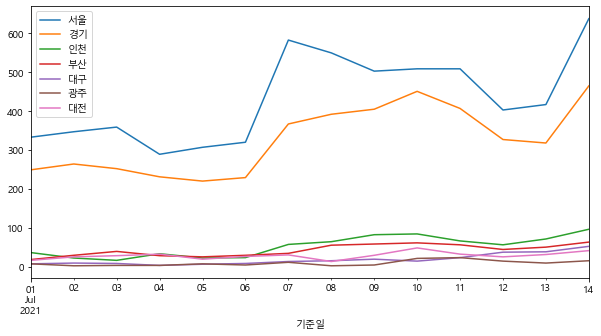

In [40]:
df2=df0[['서울','경기', '인천', '부산', '대구', '광주', '대전']]

df2.plot.(figsize=(10, 5))
plt.show()

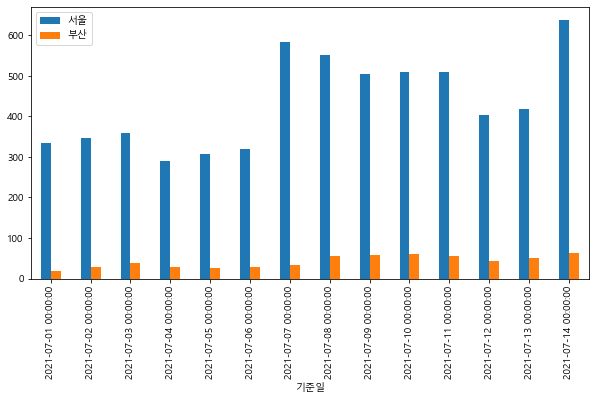

In [43]:
df2=df0[['서울','부산']]

df2.plot.bar(figsize=(10, 5))
plt.show()